<a href="https://colab.research.google.com/github/giabb/NeuralNetworks/blob/main/Deep%20Regression%20Segmentation%20for%20Cardiac%20Left-Ventricle%20MR%20Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Networks Exam
#"Sapienza" University of Rome - Spring Semester 2019
##[@giabb](https://github.com/giabb) - [@FabioDiS](https://github.com/FabioDiS)
##Deep Regression Segmentation for Cardiac Left-Ventricle MR Images

#Importing Libraries

In [ ]:
!pip install opencv-python==4.1.0.25
!pip install tensorflow-gpu

In [ ]:
#used to access files on drive
from google.colab import drive
drive.mount('/content/gdrive')

#utils
import cv2
print('Cv2 version:',cv2.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.io import loadmat
from skimage.feature import daisy

#training utilities
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

#Keras imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
print('Tensorflow version:',tf.__version__)

#various tools for analysis
from scipy.spatial import ConvexHull
from shapely.geometry.multipoint import MultiPoint
from shapely.geometry import Polygon
from osgeo import ogr
from scipy.stats import pearsonr as pcc
from scipy.spatial.distance import directed_hausdorff as dh

#checking if tensorflow/keras is working on the GPU
tf.reset_default_graph()
try:
  with tf.device('/device:GPU:0'):
      a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
      b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
      c = tf.matmul(a, b)
      # Creates a session with log_device_placement set to True.
      sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
      # Runs the op.
      r = sess.run(c)
      print('Using GPU')
except:
  print('Not using gpu')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Cv2 version: 4.1.0
Tensorflow version: 1.14.0
Using GPU


#Preprocessing

In [ ]:
#Loading matrices
mat=loadmat('gdrive/My Drive/Progetto NN/datasets/cardiac-dig.mat')
imms=mat['images_LV']
endo=mat['endo_LV']
epi=mat['epi_LV']
rwt=mat['rwt']
dims=mat['dims']
mat_test=loadmat('gdrive/My Drive/Progetto NN/datasets/lvquan_test_images_30sub.mat')
imms_test = mat_test['images_LV_30']

##Showing the starting binary mask before and after edge detection

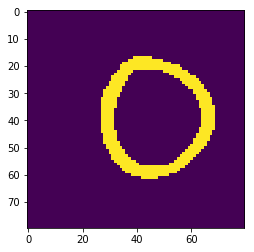

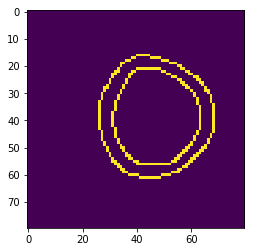

In [ ]:
plt.imshow(epi[:,:,0]-endo[:,:,0])
plt.show()
plt.imshow(cv2.Canny(epi[:,:,0]-endo[:,:,0],0,0))
plt.show()

## Finding the maximum index for the endocardium image dataset

In [ ]:
maxind = 0
minind = 200
for i in range(0,2900):
    img=endo[:,:,i]
    
    #Find contour
    cnts, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    mina=255
    maxa=0
    minb=255
    maxb=0
    for j in range(len(cnts[0])):
        a=cnts[0][j][0][1]
        b=cnts[0][j][0][0]
        mina=min(mina,a) #minimum value over the x
        maxa=max(maxa,a) #maximum value over the x
        minb=min(minb,b) #minimum value over the y
        maxb=max(maxb,b) #maximum value over the y
    cent_x = int((mina+maxa))/2
    cent_y = int((minb+maxb))/2
    center = (cent_y,cent_x)
    
    # Center contour
    cnt = np.squeeze(cnts[0]) - center

    # Calculate atan2 values, and sort by angle
    val = np.sort(np.arctan2(cnt[:, 0], cnt[:, 1]))
    idx = np.argsort(np.arctan2(cnt[:, 0], cnt[:, 1]))

    # atan2 uses (1, 0) as starting point, so correct by 1/2 * pi
    corr = np.where(val <= (-0.5 * np.pi))[0][-1]

    # Build final indices
    indFinal = np.concatenate((idx[corr - 1:], idx[0:corr]))
    x = cnt[indFinal, 0]
    y = cnt[indFinal, 1]
    x = x + cent_y
    y = y + cent_x
    
    # get maximum and minimum index
    maxind = max(maxind, len(x))
    minind = min(minind, len(x))
    
print('maxind:',maxind)
print('minind:',minind)


maxind: 119
minind: 41


##Sorting endocardium boundary points clockwise
###Explained in details in the report

In [ ]:
x_pad_endo = np.zeros(shape=((2900),maxind))
y_pad_endo = np.zeros(shape=((2900),maxind))
cont = 0
for i in range(2900):
  img=endo[:,:,i]
  #Find contours
  cnts, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  mina=255
  maxa=0
  minb=255
  maxb=0
  for j in range(len(cnts[0])):
    a=cnts[0][j][0][1]
    b=cnts[0][j][0][0]
    mina=min(mina,a)  #minimum value over the x
    maxa=max(maxa,a)  #maximum value over the x
    minb=min(minb,b)  #minimum value over the y
    maxb=max(maxb,b)  #maximum value over the y
  cent_x = int((mina+maxa))/2
  cent_y = int((minb+maxb))/2
  center = (cent_y,cent_x)
  
  # Center contour
  cnt = np.squeeze(cnts[0]) - center

  # Calculate atan2 values, and sort by angle
  val = np.sort(np.arctan2(cnt[:, 0], cnt[:, 1]))
  idx = np.argsort(np.arctan2(cnt[:, 0], cnt[:, 1]))

  # atan2 uses (1, 0) as starting point, so correct by 1/2 * pi
  corr = np.where(val <= (-0.5 * np.pi))[0][-1]

  # Build final indices
  indFinal = np.concatenate((idx[corr - 1:], idx[0:corr]))
  x = cnt[indFinal, 0]
  y = cnt[indFinal, 1]
  x = x + cent_y
  y = y + cent_x

  # Padding 
  x_pad_endo[i] = np.pad(x,(0,maxind-len(x)),'edge')#'constant', constant_values=(0,0))
  y_pad_endo[i] = np.pad(y,(0,maxind-len(y)),'edge')#'constant', constant_values=(0,0))
  

##Finding the maximum index for the epicardium image dataset

In [ ]:
maxind = 0
minind = 200
for i in range(0,2900):
    img=epi[:,:,i]
    
    #Find contours
    cnts, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    mina=255
    maxa=0
    minb=255
    maxb=0
    for j in range(len(cnts[0])):
        a=cnts[0][j][0][1]
        b=cnts[0][j][0][0]
        mina=min(mina,a) #minimum value over the x
        maxa=max(maxa,a) #maximum value over the x
        minb=min(minb,b) #minimum value over the y
        maxb=max(maxb,b) #maximum value over the y
    cent_x = int((mina+maxa))/2
    cent_y = int((minb+maxb))/2
    center = (cent_y,cent_x)
    
    #center contour
    cnt = np.squeeze(cnts[0]) - center

    # Calculate atan2 values, and sort
    val = np.sort(np.arctan2(cnt[:, 0], cnt[:, 1]))
    idx = np.argsort(np.arctan2(cnt[:, 0], cnt[:, 1]))

    # atan2 uses (1, 0) as starting point, so correct by 1/2 * pi
    corr = np.where(val <= (-0.5 * np.pi))[0][-1]

    # Build final indices
    indFinal = np.concatenate((idx[corr - 1:], idx[0:corr]))
    x = cnt[indFinal, 0]
    y = cnt[indFinal, 1]
    x = x + cent_y
    y = y + cent_x
    
    # Find maximum and minimum index
    maxind = max(maxind, len(x))
    minind = min(minind, len(x))
    
print('maxind:',maxind)
print('minind:',minind)

maxind: 157
minind: 85


##Sorting epicardium boundary points clockwise
###Explained in details in the report

In [ ]:
x_pad_epi = np.zeros(shape=((2900),maxind))
y_pad_epi = np.zeros(shape=((2900),maxind))
cont = 0
for i in range(2900):
  img=epi[:,:,i]
  #Find contours
  cnts, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  mina=255
  maxa=0
  minb=255
  maxb=0
  for j in range(len(cnts[0])):
    a=cnts[0][j][0][1]
    b=cnts[0][j][0][0]
    mina=min(mina,a) #minimum value over the x
    maxa=max(maxa,a) #maximum value over the x
    minb=min(minb,b) #minimum value over the y
    maxb=max(maxb,b) #maximum value over the y
  cent_x = int((mina+maxa))/2
  cent_y = int((minb+maxb))/2
  center = (cent_y,cent_x)
  
  # Center contour
  cnt = np.squeeze(cnts[0]) - center

  # Calculate atan2 values, and sort
  val = np.sort(np.arctan2(cnt[:, 0], cnt[:, 1]))
  idx = np.argsort(np.arctan2(cnt[:, 0], cnt[:, 1]))

  # atan2 uses (1, 0) as starting point, so correct by 1/2 * pi
  corr = np.where(val <= (-0.5 * np.pi))[0][-1]

  # Build final indices
  indFinal = np.concatenate((idx[corr - 1:], idx[0:corr]))
  x = cnt[indFinal, 0]
  y = cnt[indFinal, 1]
  x = x + cent_y
  y = y + cent_x

  # Padding
  x_pad_epi[i] = np.pad(x,(0,maxind-len(x)),'edge')#'constant', constant_values=(0,0))
  y_pad_epi[i] = np.pad(y,(0,maxind-len(y)),'edge')#'constant', constant_values=(0,0))

##Daisy feature extraction
###Also showing an example of DAISY features applied on the starting image and reshaped in a heatmap.

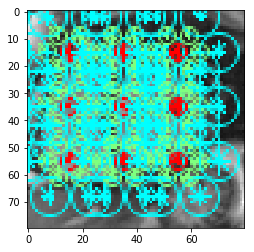

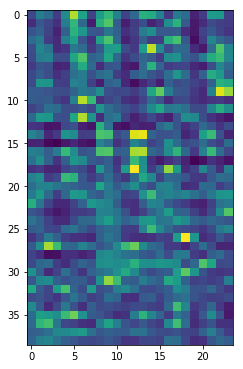

In [ ]:
flag = False
for i in range(0,2900):
  descs, descs_img = daisy(imms[:,:,i], step=20, radius=15, rings=2, histograms=6, orientations=8, visualize=True)
  descs = descs.reshape(1,INPUT_DIM)
  if not flag:
    flag = True
    descs_reshape = descs
    plt.imshow(descs_img)
    plt.figure(figsize=(10,8/1.3))
    plt.imshow(descs_reshape.reshape(39,24), cmap='viridis', interpolation='nearest')
    plt.colorbar()
  else:
    descs_reshape = np.concatenate((descs_reshape, descs), axis=0) 

##Concatenating bounary points representation
###In order to get an unic feature vector for each image

In [ ]:
boundaries_epi = np.zeros(shape=(2900,(x_pad_epi.shape[1]+y_pad_epi.shape[1])))
boundaries_endo = np.zeros(shape=(2900,(x_pad_endo.shape[1]+y_pad_endo.shape[1])))
boundaries_lv = np.zeros(shape=(2900,(boundaries_epi.shape[1]+boundaries_endo.shape[1])))
for i in range(2900):
    boundaries_epi[i] = np.concatenate((x_pad_epi[i],y_pad_epi[i]),axis=0)
    boundaries_endo[i] = np.concatenate((x_pad_endo[i],y_pad_endo[i]),axis=0)
    boundaries_lv[i] = np.concatenate((boundaries_epi[i],boundaries_endo[i]),axis=0)

print("epi: ",boundaries_epi.shape)
print("endo: ",boundaries_endo.shape)  
print("lv: ",boundaries_lv.shape)

epi:  (2900, 314)
endo:  (2900, 238)
lv:  (2900, 552)


#Deep AutoEncoder for Regression

![Model Summary](https://drive.google.com/open?id=1UTEVsuI8Xe395SIfpfeP34Yq_TzEQrO3)

In [ ]:
#Auto Encoder
model = Sequential()

#Encode Layers
model.add(Dense(768,activation="relu",name='Encode_1',input_shape=(INPUT_DIM,)))
model.add(Dropout(0.5, name='Dropout_1'))
model.add(Dense(256, activation="relu", name='Encode_2'))
model.add(Dropout(0.5,name='Dropout_2'))
model.add(Dense(128, activation="relu", name='Encode_3'))
model.add(Dropout(0.5,name='Dropout_3'))

#Latent Space
model.add(Dense(10, activation="sigmoid", name='Latent_View'))

#Decode Layers
model.add(Dense(128, activation="relu", name='Decode_1'))
model.add(Dense(256, activation="relu", name='Decode_2'))
model.add(Dense(768, activation="relu", name='Decode_3'))

#Output
model.add(Dense(552, activation = 'linear', name='Output'))

#The choice of these functions is explained in the report
model.compile(loss='mean_absolute_error', optimizer='RMSProp', metrics=['mse'])
model.summary()

W0708 09:25:08.797433 139714423252864 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encode_1 (Dense)             (None, 768)               719616    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
Encode_2 (Dense)             (None, 256)               196864    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
Encode_3 (Dense)             (None, 128)               32896     
_________________________________________________________________
Dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
Latent_View (Dense)          (None, 10)                1

##Defining a logger to better follow the training phase

In [ ]:
class AccuracyHistory(tf.keras.callbacks.Callback):  
    def __init__(self):
        self.acc = []
        self.loss = []
        self.val_acc = []
        self.val_loss = []
        self.iter = 1
    
    def on_train_begin(self, logs={}):
        print("\nStarting training, iteration {}".format(self.iter))
        self.epoch = 1

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('mean_squared_error'))
        self.loss.append(logs.get('loss'))
        self.val_acc.append(logs.get('val_mean_squared_error'))
        self.val_loss.append(logs.get('val_loss'))
        self.epoch += 1

    def on_train_end(self, logs={}):
        print("Ended training, iteration {}".format(self.iter))
        print('mean_squared_error:',self.acc[-1],'- loss:',self.loss[-1],'- val_mean_squared_error:',self.val_acc[-1],'- val_loss:',self.val_loss[-1])
        #model.save('gdrive/My Drive/Progetto NN/logging/model_keras_iter{}.ckpt'.format(self.iter))
        self.iter += 1

##Leave-one-out 
###Implementation of the Leave-one-out cross-validation (but used as testing). Since the images in the dataset are just 2900, we chose to implement this method in order to randomize every 100 epochs the images, to improve performances.

In [ ]:
#tf.reset_default_graph()

history = AccuracyHistory()

test_acc = []
test_loss = []

prova = np.arange(2900).reshape(145,20)
loo = LeaveOneOut()
for train_index, test_index in loo.split(prova):
    test_x = np.zeros(shape=(20,INPUT_DIM))
    train_x = np.zeros(shape=(2880,INPUT_DIM))
    test_y = np.zeros(shape=(20,552))
    train_y = np.zeros(shape=(2880,552))
    for ind, index in enumerate(prova[test_index[0]]):
        #print(index)
        test_x[ind] = descs_reshape[index]
        test_y[ind] = boundaries_lv[index]
    for ind, index in enumerate(prova[train_index].reshape(2880)):
        #print(index)
        train_x[ind] = descs_reshape[index]
        train_y[ind] = boundaries_lv[index]
        
    x_train, x_dev, y_train, y_dev = train_test_split(train_x, train_y, test_size=0.2, random_state = 42, shuffle = True) # 0.2 test_size means 20%
        
    data = model.fit(
        x=x_train, 
        y=y_train, 
        batch_size=64, 
        epochs=100,
        validation_data=(x_dev, y_dev),
        shuffle=True,
        callbacks=[history],
        verbose = 0
    )
    
    print("Evaluating test...")
    loss_acc = model.evaluate(test_x, test_y, verbose=1)
    test_loss.append(loss_acc[0])
    test_acc.append(loss_acc[1])
    
model.save('gdrive/My Drive/Progetto NN/logging/model_keras.ckpt')


Starting training, iteration 1
Ended training, iteration 1
mean_squared_error: 28.073761 - loss: 3.8000388277901544 - val_mean_squared_error: 24.932882 - val_loss: 3.568121486239963
Evaluating test...
20/20 [==============================] - 0s 87us/sample - loss: 2.8867 - mean_squared_error: 15.0197

Starting training, iteration 2
Ended training, iteration 2
mean_squared_error: 26.672005 - loss: 3.6348961657947965 - val_mean_squared_error: 23.685347 - val_loss: 3.324177000257704
Evaluating test...
20/20 [==============================] - 0s 98us/sample - loss: 3.9358 - mean_squared_error: 34.7049

Starting training, iteration 3
Ended training, iteration 3
mean_squared_error: 26.2018 - loss: 3.572752442624834 - val_mean_squared_error: 24.15945 - val_loss: 3.343023353152805
Evaluating test...
20/20 [==============================] - 0s 107us/sample - loss: 3.2330 - mean_squared_error: 22.0533

Starting training, iteration 4
Ended training, iteration 4
mean_squared_error: 14.228455 - lo

##Write results on file

In [ ]:
'''with open('/content/gdrive/My Drive/Progetto NN/logging/data/accuracy_log.txt', 'w+') as f:
  for line in history.acc:
    f.write(str(line)+'\n')

with open('/content/gdrive/My Drive/Progetto NN/logging/data/loss_log.txt', 'w+') as f:
  for line in history.loss:
    f.write(str(line)+'\n')
    
with open('/content/gdrive/My Drive/Progetto NN/logging/data/val_accuracy_log.txt', 'w+') as f:
  for line in history.val_acc:
    f.write(str(line)+'\n')
    
with open('/content/gdrive/My Drive/Progetto NN/logging/data/val_loss_log.txt', 'w+') as f:
  for line in history.val_loss:
    f.write(str(line)+'\n')
    
with open('/content/gdrive/My Drive/Progetto NN/logging/data/test_loss_log.txt', 'w+') as f:
  for line in test_loss:
    f.write(str(line)+'\n')
    
with open('/content/gdrive/My Drive/Progetto NN/logging/data/test_acc_log.txt', 'w+') as f:
  for line in test_acc:
    f.write(str(line)+'\n')'''

#Result Analysis

##DAISY feature extraction 

In [ ]:
#generate test
flag = False
for i in range(0,600):
    descs_test, descs_test_img = daisy(imms_test[:,:,i], step=20, radius=15, rings=2, histograms=6, orientations=8, visualize=True)
    descs_test = descs_test.reshape(1,INPUT_DIM)
    if not flag:
        flag = True
        descs_test_reshape = descs_test
    else:
        descs_test_reshape = np.concatenate((descs_test_reshape, descs_test), axis=0) 

##Usefull functions to make the code more readable

In [ ]:
''' GetPoints function takes as input 2 arrays of same size N, X and Y.
Returns as output an array of coordinates shaped (N,2)'''
def GetPoints(x,y):
  points = []
  for x0, y0 in zip(x,y):
    temp = []
    temp.append(x0)
    temp.append(y0)
    points.append(temp)
  return np.asarray(points)

'''GetArea function takes as input 2 arrays of same size N, X and Y.
Returns the area of the convex hull obtained from the coordinates defined
by the function GetPoints(x,y)'''

def GetArea(x,y):
  p = GetPoints(x,y)
  h = ConvexHull(p)
  return h.volume

'''
GetDM function takes as input 4 arrays. 2 of size N, x_orig and y_orig, and 2 of
size M, x_pred and y_pred. It computes the 2 convex hulls related to the 2 pairs
of arrays, intersects them and gets the coordinates of the points of the convex
hull of the intersection. Than computes the area of these 3 convex hulls.
Returns the dice metric related to these 3 areas (explained in the report)
'''

def GetDM(x_orig, y_orig, x_pred, y_pred):
  p1 = GetPoints(x_pred, y_pred)
  p2 = GetPoints(x_orig, y_orig)

  h1 = MultiPoint(p1).convex_hull
  h2 = MultiPoint(p2).convex_hull

  poly1 = ogr.CreateGeometryFromWkt(str(h1))
  poly2 = ogr.CreateGeometryFromWkt(str(h2))

  intersection = poly1.Intersection(poly2)
  
  strcoord = intersection.ExportToWkt().replace('POLYGON ((','').replace('))','').split(',')
  coordinates = []
  for coord in strcoord:
    temp = coord.split()
    for i in range(2):
      try:
        temp[i] = int(temp[i])
      except ValueError:
        temp[i] = float(temp[i])
        temp[i] = int(temp[i])
    coordinates.append(temp)
  coordinates = np.asarray(coordinates)

  hint = MultiPoint(coordinates).convex_hull

  areaint = ConvexHull(coordinates).volume
  areapred = ConvexHull(p1).volume
  areaorig = ConvexHull(p2).volume

  dm = 2 * areaint / (areapred + areaorig)

  return dm

'''
DrawHull function draws, starting from a set of points, the related convex hull
'''

def DrawHull(x,y,c):
  p = GetPoints(x,y)
  h = ConvexHull(p)
  for simplex in h.simplices:
    plt.plot(p[simplex, 0], p[simplex, 1], c, linewidth = 2)
    
def GetBAP(data1, data2, name):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, label=name, c='orange', s=0.7)
    plt.xlabel('Means')
    plt.ylabel('Differences')
    plt.axhline(md,           color='b', linestyle='-')
    plt.axhline(md + 1.96*sd, color='r', linestyle='--')
    plt.axhline(md - 1.96*sd, color='r', linestyle='--')

#Predictions

In [ ]:
model_load = tf.keras.models.load_model('gdrive/My Drive/Progetto NN/logging/model_keras.ckpt')

In [ ]:
pred = model_load.predict(descs_reshape)

##Getting some random predictions on the entire set

In [ ]:
#Generate plot
rand_gen = np.random.randint(0,2900,size=30)
for val in rand_gen:
  pred_x_epi = pred[val,0:157].astype(int)
  pred_y_epi = pred[val,157:314].astype(int)
  pred_x_endo = pred[val,314:433].astype(int)
  pred_y_endo = pred[val,433:552].astype(int)

  orig_x_epi = boundaries_lv[val,0:157]
  orig_y_epi = boundaries_lv[val,157:314]
  orig_x_endo = boundaries_lv[val,314:433]
  orig_y_endo = boundaries_lv[val,433:552]

  plt.figure(figsize=(4,4))
  DrawHull(pred_x_endo,pred_y_endo,'r-')
  DrawHull(pred_x_epi,pred_y_epi,'r-')
  DrawHull(orig_x_epi,orig_y_epi,'y-')
  DrawHull(orig_x_endo,orig_y_endo,'y-')
  plt.savefig('gdrive/My Drive/Progetto NN/IMG/Cuori/{}.jpg'.format(val))
  plt.show()

##Plotting predicted coordinates

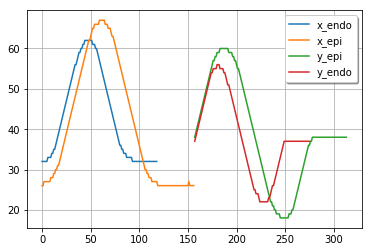

In [ ]:
plt.plot(np.arange(119),pred[0,314:433].astype(int), label='x_endo')
plt.plot(np.arange(157),pred[0,0:157].astype(int), label='x_epi')
plt.plot(np.arange(157,314),pred[0,157:314].astype(int), label='y_epi')
plt.plot(np.arange(157,276),pred[0,433:552].astype(int), label='y_endo')
plt.legend(shadow = True)
plt.grid(True)
plt.savefig('plot.png')

##Plotting original coordinates

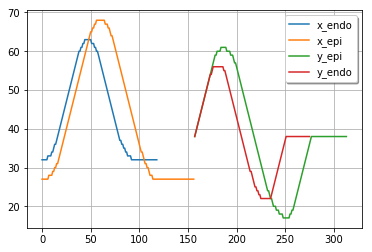

In [ ]:
plt.plot(np.arange(119),x_pad_endo[0], label='x_endo')
plt.plot(np.arange(157),x_pad_epi[0], label='x_epi')
plt.plot(np.arange(157,314),y_pad_epi[0], label='y_epi')
plt.plot(np.arange(157,276),y_pad_endo[0], label='y_endo')
plt.legend(shadow = True)
plt.grid(True)
plt.savefig('plot.png')

#Analysis

##Calculating values for testing

In [ ]:
dms_epi = []
dms_endo = []
pccs_epi_x = []
pccs_epi_y = []
pccs_endo_x = []
pccs_endo_y = []
dhs_epi = []
dhs_endo = []
areas_epi_pred = []
areas_endo_pred = []
areas_epi_orig = []
areas_endo_orig = []

for val in range(2900):
  pred_x_epi = pred[val,0:157].astype(int)
  pred_y_epi = pred[val,157:314].astype(int)
  pred_x_endo = pred[val,314:433].astype(int)
  pred_y_endo = pred[val,433:552].astype(int)

  orig_x_epi = boundaries_lv[val,0:157]
  orig_y_epi = boundaries_lv[val,157:314]
  orig_x_endo = boundaries_lv[val,314:433]
  orig_y_endo = boundaries_lv[val,433:552]
  
  dms_epi.append(GetDM(pred_x_epi, pred_y_epi, orig_x_epi, orig_y_epi))
  dms_endo.append(GetDM(pred_x_endo, pred_y_endo, orig_x_endo, orig_y_endo))
  pccs_epi_x.append(pcc(pred_x_epi, orig_x_epi)[0])
  pccs_epi_y.append(pcc(pred_y_epi, orig_y_epi)[0])
  pccs_endo_x.append(pcc(pred_x_endo, orig_x_endo)[0])
  pccs_endo_y.append(pcc(pred_y_epi, orig_y_epi)[0])
  dhs_epi.append(dh(GetPoints(orig_x_epi, orig_y_epi),GetPoints(pred_x_epi, pred_y_epi))[0])
  dhs_endo.append(dh(GetPoints(orig_x_endo, orig_y_endo), GetPoints(pred_x_endo, pred_y_endo))[0])
  areas_endo_pred.append(GetArea(pred_x_endo, pred_y_endo))
  areas_epi_pred.append(GetArea(pred_x_epi, pred_y_epi))
  areas_endo_orig.append(GetArea(orig_x_endo, orig_y_endo))
  areas_epi_orig.append(GetArea(orig_x_epi, orig_y_epi))

 ## Calculating average Dice Metric for each subject

In [ ]:
dms_epi_subj = []
dms_endo_subj = []

for dm in range(145):
  temp = (sum(dms_epi[dm*20:(dm+1)*20]) / len(dms_epi[dm*20:(dm+1)*20]))
  dms_epi_subj.append(temp)
  
for dm in range(145):
  temp = (sum(dms_endo[dm*20:(dm+1)*20]) / len(dms_endo[dm*20:(dm+1)*20]))
  dms_endo_subj.append(temp)

##Plotting average Dice Metric for each subject

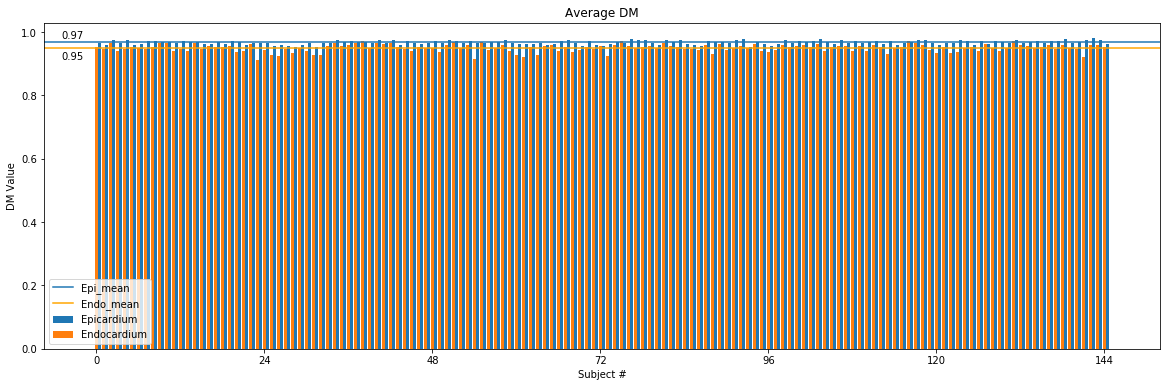

In [ ]:
indices = np.arange(145)
m_epi = sum(dms_epi_subj)/len(dms_epi_subj)
m_endo = sum(dms_endo_subj)/len(dms_endo_subj)

pari = []
dispari = []

for i in indices:
  dispari.append(i)
  pari.append(i+0.5)

plt.figure(figsize=(20,6))
plt.title('Average DM')
plt.bar(pari,[x for x in dms_epi_subj], label='Epicardium', width=0.45)
plt.bar(dispari,[x for x in dms_endo_subj], label='Endocardium', width=0.45)
plt.xlabel('Subject #')
plt.ylabel('DM Value')
plt.axhline(m_epi, linestyle='-', label = 'Epi_mean')
plt.text(-5,0.98,'{}'.format(round(m_epi,2)))
plt.axhline(m_endo, color='orange', linestyle='-', label='Endo_mean')
plt.text(-5,0.915,'{}'.format(round(m_endo,2)))
plt.legend()
plt.xticks([0,24,24*2,24*3,24*4,24*5,24*6])
plt.savefig('gdrive/My Drive/Progetto NN/IMG/bars.png', bbox_inches='tight')

##Plotting Bland-Altman and Linear Regression Analysis

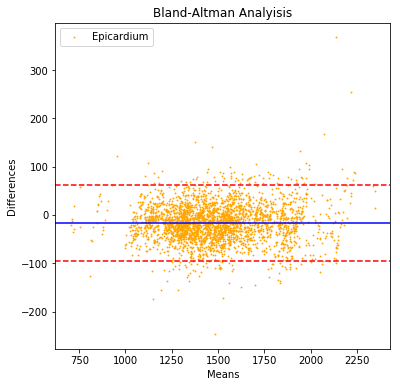

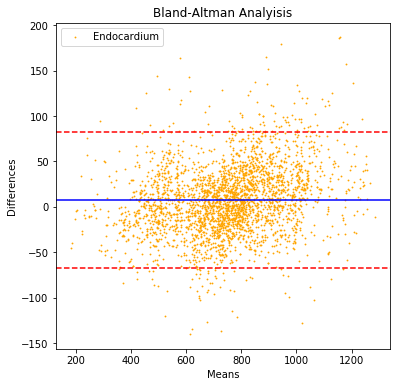

In [ ]:
plt.figure(figsize=(6,6))
plt.title('Bland-Altman Analyisis')
GetBAP(areas_epi_orig,areas_epi_pred, 'Epicardium')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Progetto NN/IMG/BAP_epi.png')

plt.figure(figsize=(6,6))
plt.title('Bland-Altman Analyisis')
GetBAP(areas_endo_orig,areas_endo_pred, 'Endocardium')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Progetto NN/IMG/BAP_endo.png')

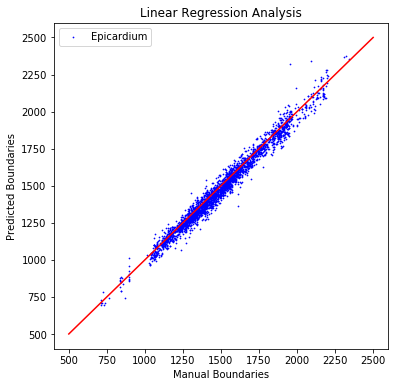

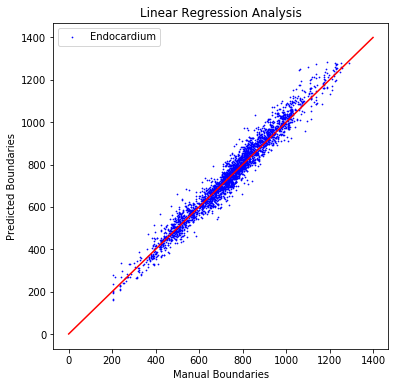

In [ ]:
plt.figure(figsize=(6,6))
plt.title('Linear Regression Analysis')
plt.scatter(np.asarray(areas_epi_pred), np.asarray(areas_epi_orig), s=0.5, c='b', label ='Epicardium')
plt.xlabel('Manual Boundaries')
plt.ylabel('Predicted Boundaries')
plt.plot([500,2500], [500,2500], c='r')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Progetto NN/IMG/blue.png')

plt.figure(figsize=(6,6))
plt.title('Linear Regression Analysis')
plt.scatter(np.asarray(areas_endo_pred), np.asarray(areas_endo_orig), s=0.5, c='b',  label ='Endocardium')
plt.xlabel('Manual Boundaries')
plt.ylabel('Predicted Boundaries')
plt.plot([0,1400], [0,1400], c='r')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Progetto NN/IMG/red.png')


##Final Numerical Results

In [ ]:
print(sum(dms_endo) / len(dms_endo))
print(sum(pccs_epi_x) / len(pccs_epi_x))
print(sum(pccs_epi_y) / len(pccs_epi_y))
print(sum(pccs_endo_x) / len(pccs_endo_x))
print(sum(pccs_endo_y) / len(pccs_endo_y))
print(sum(dhs_epi) / len(dhs_epi))
print(sum(dhs_endo) / len(dhs_endo))

0.9675672911657027
0.950026817859011
0.9986655510012755
0.998086286224043
0.9961231296384672
0.998086286224043
1.9671507424070347
2.037605101478414
